# Some Simple Remote Sensing Band Math in Python

In this Jupyter notebook, I perform 

In [1]:
%matplotlib inline

from osgeo import gdal
import rasterio
import matplotlib.pyplot as plt
import numpy as np

plt.rc('font', size=8)
plt.rc('axes', titlesize=8)
plt.rc('axes', labelsize=8)
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('figure', titlesize=8)

In [2]:
L8_BLUE_fn  = 'LC08_CU_008006_20170510_20171018_C01_V01_SRB2.tif'
L8_GREEN_fn = 'LC08_CU_008006_20170510_20171018_C01_V01_SRB3.tif'
L8_RED_fn   = 'LC08_CU_008006_20170510_20171018_C01_V01_SRB4.tif'
L8_NIR_fn   = 'LC08_CU_008006_20170510_20171018_C01_V01_SRB5.tif'
L8_SWIR1_fn = 'LC08_CU_008006_20170510_20171018_C01_V01_SRB6.tif'
L8_SWIR2_fn = 'LC08_CU_008006_20170510_20171018_C01_V01_SRB7.tif'

## Load the Data with GDAL

In [3]:
ds_blue  = gdal.Open(L8_BLUE_fn)   # The blue band
ds_green = gdal.Open(L8_GREEN_fn)  # The green band
ds_red   = gdal.Open(L8_RED_fn)    # The red band
ds_nir   = gdal.Open(L8_NIR_fn)    # The near infrared band
ds_swir1 = gdal.Open(L8_SWIR1_fn)  # The first SWIR band
ds_swir2 = gdal.Open(L8_SWIR2_fn)  # The second SWIR band

# Extract the pixel values
B2_values = ds_blue.ReadAsArray() 
B3_values = ds_green.ReadAsArray()
B4_values = ds_red.ReadAsArray()
B5_values = ds_nir.ReadAsArray()
B6_values = ds_swir1.ReadAsArray()
B7_values = ds_swir2.ReadAsArray()

# Lets look at the shape of this data
print(B2_values.shape)

(5000, 5000)


### An Important Aside on Storing Geospatial Raster Data
The Landsat TOA data are stored as integers for size purposes. Many datasets, particularly geospatial raster data are, in fact, stored in this way. The reason for this is that it can sometimes take considerably less disk space to store things as integers than as floating point data. I can then give you one floating point value that corresponds to a "scale" parameter that allows you to convert that integer data into the actual units of the variable being stored. For example, say we have measurements of soil moisture that we know (e.g., because the manufacturer of our probe tells us) have three significant figures. A measurement of soil moisture from our probe might be:

$\theta = 0.027$ m${}^3$/m${}^3$

Storing this as a double-precision floating point variable will typically require 64 bits of space on our computer. If we now multiply this number by 1000, we can store our soil moisture value as:

$\theta_{scaled} = 27$

If we store this as a "short" integer, it typically requires 16 bits, we achieve a compression of 4 times compared with storing it as a double. Note that we **do not** lose any precision by doing this because we aren't truncating any significant figures. We chose 1000 thoughtfully because this preserves all of the precision of the hardware doing the measuring.

Now, we still need to store the 1000 and make it unambiguous that you have to divide by 1000 to get soil moisture in the correct units. So that would require 16 bits more if I stored 1000, or 64 bits if I stored 0.001 and told you to multiply $\theta_{scaled}$ by this "scale factor" to get the correct number. If it was just one number, that would mean I needed 80 bits to store $\theta_{scaled}$ and scale factor (as 0.001). That doesn't make sense of a single number. However, what you'll notice about our Landsat tiles is that they are 5000 x 5000, or contain 25,000,000 pixel values. So, let's look at two different storage calculation scenarios:

1. Store as double-precision float: 5000 x 5000 x 64 bits = 1.6 x 10${}^9$ bits = **200 MB**
2. Convert to integer and store a single scale factor as a double precision float: 5000 x 5000 x 16 bits + 64 bits = 4.0 x 10${}^8$ = **50 MB**

So, clearly, if you're storing large numbers of observations (like remote sensing imagery or model output), it makes sense to convert to integers and then store an additional scale factor that the user must multiply by to retrieve the original data. And all of this is before there are any fancy image compression techniques that might save us additional space.

The very clear and important implication, then, is that you - the user - must be very careful to review all appropriate metadata of any data you get from public repositories to understand how it is stored and what you have to do to convert it to what you want. The other implication is that you - as a provider of data - need to adequately describe your data (i.e., with metadata) so that other users can reproduce your data.

In this example with Landsat data, it came with a metadata file named 'LC08_CU_008006_20170510_20171018_C01_V01.xml' that tells us that for all the bands of Landsat we're interested in, we need to multiply by 0.000100 to get the correct data out. 

Below, we convert our retrieved matrices to double-precision floating point variables, assign anything less than 0 to being a nan, and then multiply by our scale factor.

In [4]:
B2_values = B2_values.astype(np.float64)
B3_values = B3_values.astype(np.float64)
B4_values = B4_values.astype(np.float64)
B5_values = B5_values.astype(np.float64)
B6_values = B6_values.astype(np.float64)
B7_values = B7_values.astype(np.float64)

B2_values[B2_values < 0] = np.nan
B3_values[B3_values < 0] = np.nan
B4_values[B4_values < 0] = np.nan
B5_values[B5_values < 0] = np.nan
B6_values[B6_values < 0] = np.nan
B7_values[B7_values < 0] = np.nan

B2_values *= 0.000100
B3_values *= 0.000100
B4_values *= 0.000100
B5_values *= 0.000100
B6_values *= 0.000100
B7_values *= 0.000100

## Visualize the Band Data

In [5]:
plt.figure(figsize=(12,18), dpi=150)

plt.subplot(3,2,1)
plt.title('Landsat 8 band 2 (Blue)')
plt.imshow(B2_values, cmap='PuOr')
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3,2,2)
plt.title('Landsat 8 band 3 (Green)')
plt.imshow(B3_values, cmap='PuOr')
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3,2,3)
plt.title('Landsat 8 band 4 (Red)')
plt.imshow(B4_values, cmap='PuOr')
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3,2,4)
plt.title('Landsat 8 band 5 (NIR)')
plt.imshow(B5_values, cmap='PuOr')
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3,2,5)
plt.title('Landsat 8 band 6 (SWIR1)')
plt.imshow(B6_values, cmap='PuOr')
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(3,2,6)
plt.title('Landsat 8 band 6 (SWIR2)')
plt.imshow(B7_values, cmap='PuOr')
plt.colorbar(fraction=0.046, pad=0.04)

plt.show()

## Compute Key Spectral Indices

In [6]:
# The Normalized Difference Snow Index (NDSI)
NDSI = (B3_values - B6_values) / (B3_values + B6_values)

# Some spectral indices that relate to water 
NDWI = (B3_values - B5_values) / (B3_values + B5_values)
MNDWI36 = (B3_values - B6_values) / (B3_values + B6_values)
MNDWI37 = (B3_values - B7_values) / (B3_values + B7_values)
AWEInsh = 4.0*(B3_values - B6_values) - (0.25*B5_values + 2.75*B7_values)
AWEIsh = B2_values + 2.5*B3_values - 1.5*(B5_values + B6_values) - 0.25*B7_values

# The Normalized Difference Vegetation Index
NDVI = (B4_values - B5_values) / (B4_values + B5_values)

## Visualize the NDSI and Make a Map of Snow Covered Area

In [7]:
plt.figure(figsize=(4,4), dpi=150)
plt.title('Landsat 8 Normalized Difference \n Snow Index (NDSI)')
plt.imshow(NDSI, cmap='gist_gray')
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

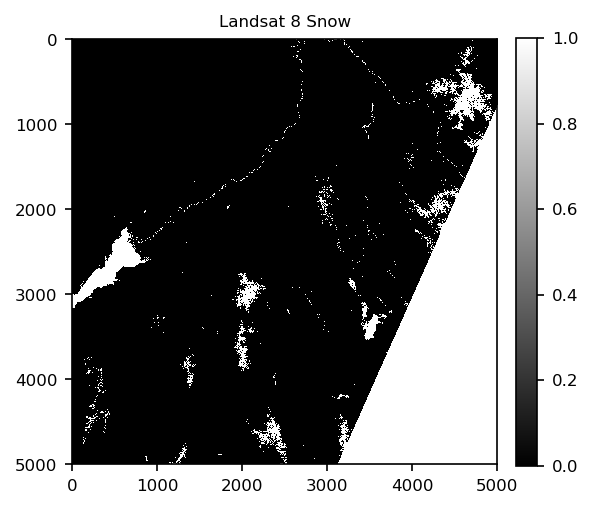

In [8]:
SnowMap = np.zeros((NDSI.shape))

NO_DATA_const = -9999.0

NDSI_threshold = 0.40
SnowMap[np.isnan(NDSI)] = NO_DATA_const
SnowMap[~np.isnan(NDSI)] = NDSI[~np.isnan(NDSI)]
SnowMap[(SnowMap >= NDSI_threshold) & (SnowMap != NO_DATA_const)] = 1.0
SnowMap[(SnowMap < NDSI_threshold) & (SnowMap != NO_DATA_const)] = 0.0
SnowMap[SnowMap == NO_DATA_const] = np.nan

plt.figure(figsize=(4,4), dpi=150)
plt.title('Landsat 8 Snow')
plt.imshow(SnowMap, cmap='gist_gray')
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

## Visualize Surface Water Indices and Make a Surface Water Body Map

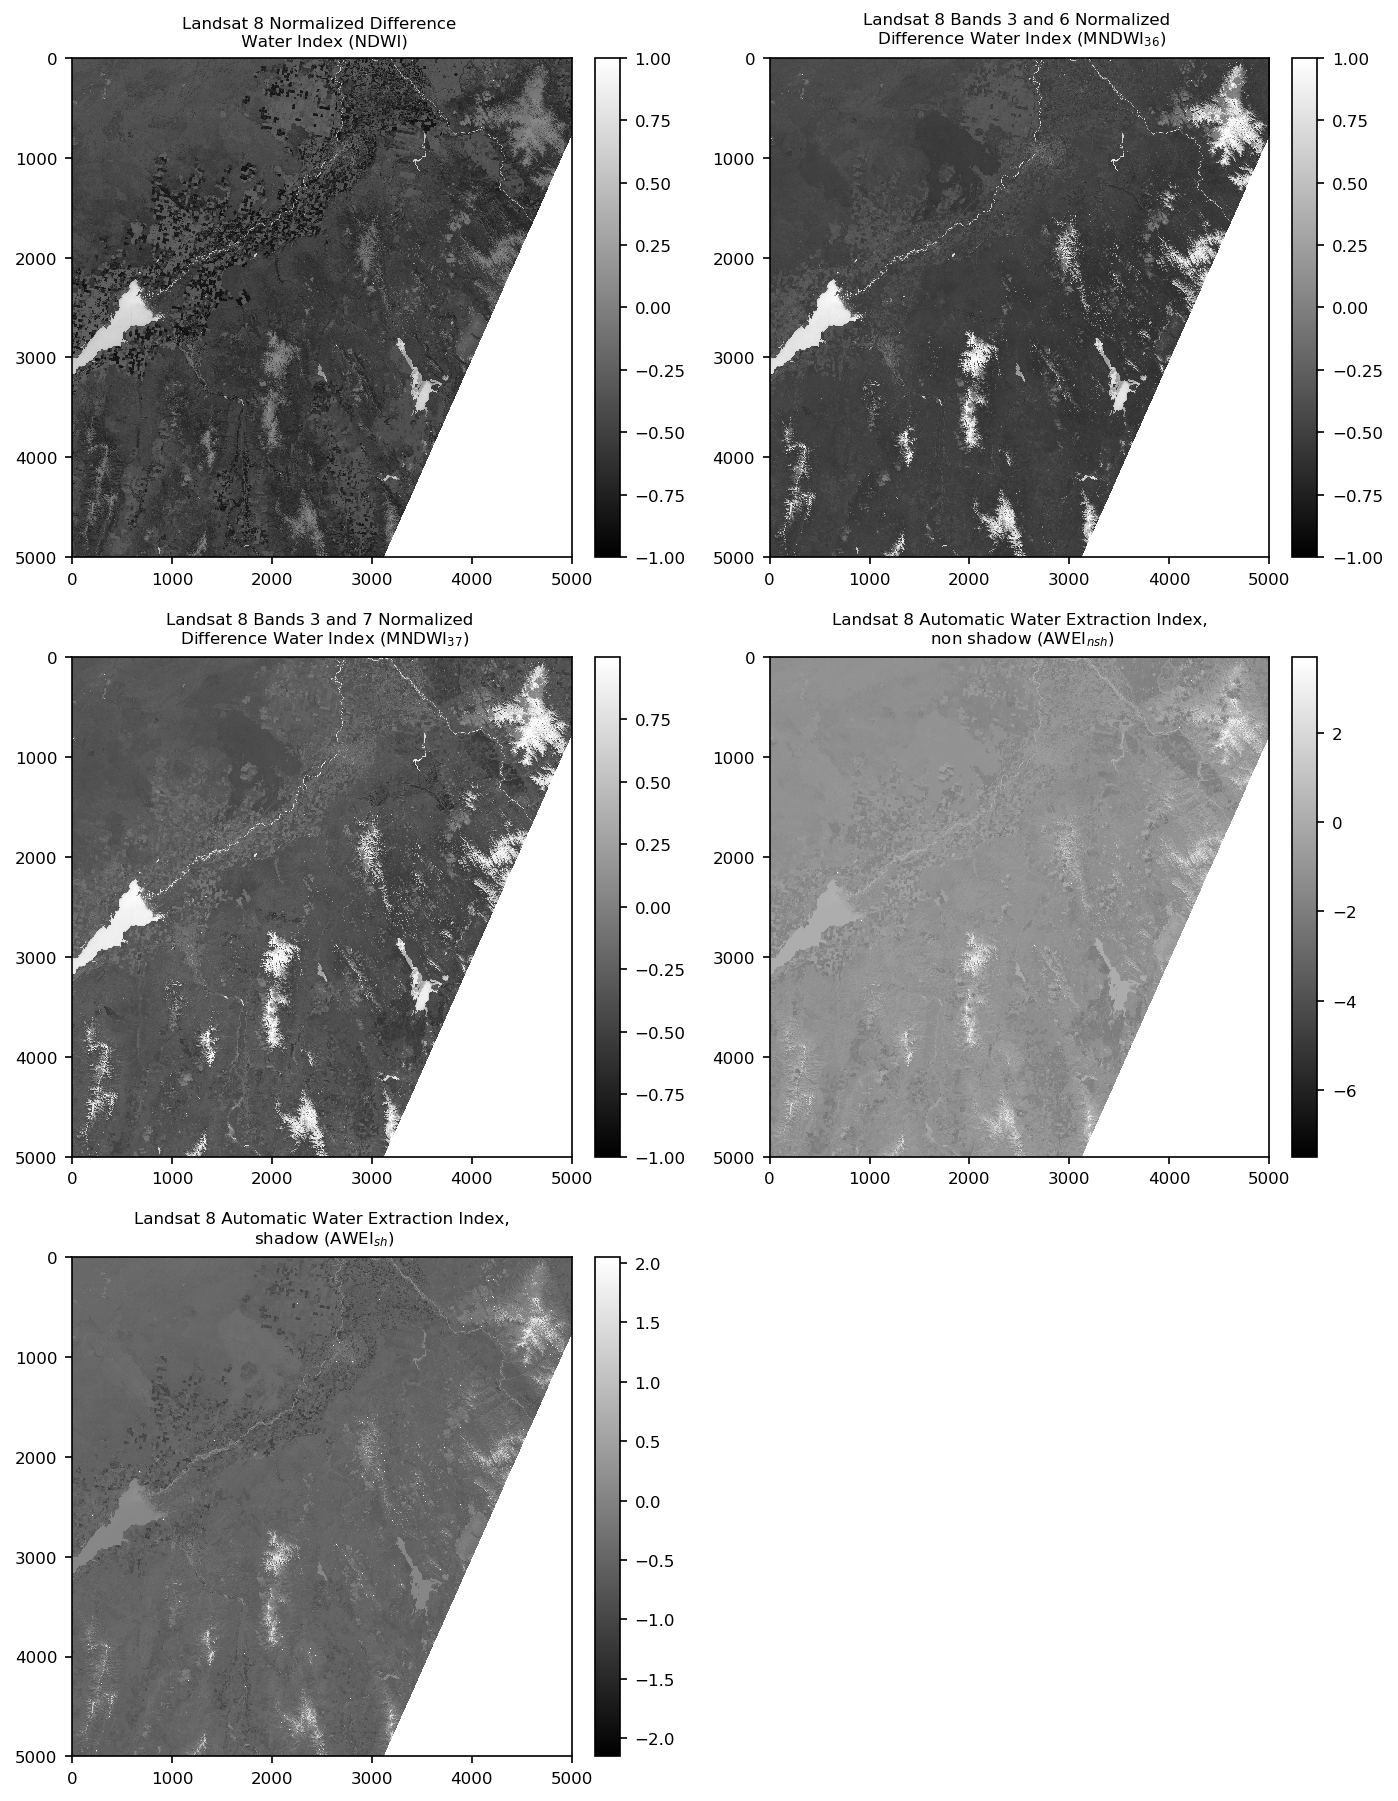

In [9]:
plt.figure(figsize=(11,15), dpi=150)
plt.subplot(3,2,1)
plt.title('Landsat 8 Normalized Difference \n Water Index (NDWI)')
plt.imshow(NDWI, cmap='gist_gray')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(3,2,2)
plt.title('Landsat 8 Bands 3 and 6 Normalized \n Difference Water Index (MNDWI${}_{36}$)')
plt.imshow(MNDWI36, cmap='gist_gray')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(3,2,3)
plt.title('Landsat 8 Bands 3 and 7 Normalized \n Difference Water Index (MNDWI${}_{37}$)')
plt.imshow(MNDWI37, cmap='gist_gray')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(3,2,4)
plt.title('Landsat 8 Automatic Water Extraction Index,\n non shadow (AWEI${}_{nsh}$)')
plt.imshow(AWEInsh, cmap='gist_gray')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(3,2,5)
plt.title('Landsat 8 Automatic Water Extraction Index,\n shadow (AWEI${}_{sh}$)')
plt.imshow(AWEIsh, cmap='gist_gray')
plt.colorbar(fraction=0.046, pad=0.04)


plt.show()

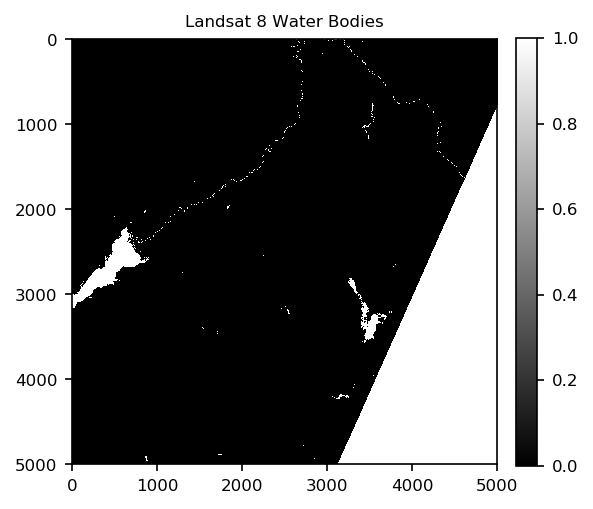

In [10]:
WaterMap = np.zeros((NDWI.shape))

NO_DATA_const = -9999.0
NDWI_threshold = 0.25
WaterMap[np.isnan(NDWI)] = NO_DATA_const
WaterMap[~np.isnan(NDWI)] = NDWI[~np.isnan(NDWI)]
WaterMap[(WaterMap >= NDWI_threshold) & (WaterMap != NO_DATA_const)] = 1.0
WaterMap[(WaterMap < NDWI_threshold) & (WaterMap != NO_DATA_const)] = 0.0
WaterMap[WaterMap == NO_DATA_const] = np.nan

plt.figure(figsize=(4,4), dpi=150)
plt.title('Landsat 8 Water Bodies')
plt.imshow(WaterMap, cmap='gist_gray')
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

## Use the Water Body Map to Correct Snow Cover

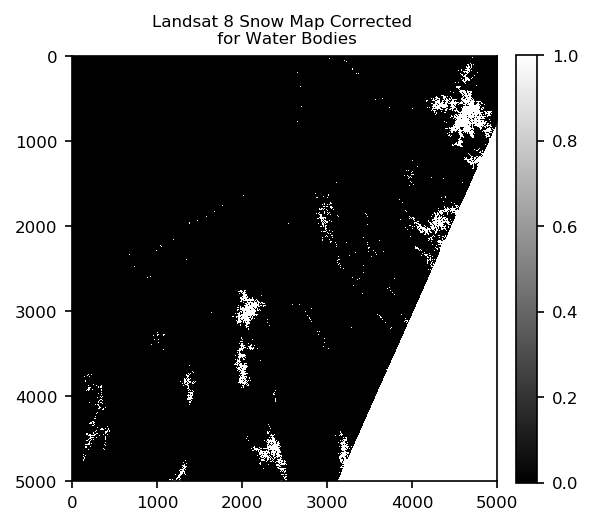

In [11]:
SnowMapCorrected = np.copy(SnowMap)

NO_DATA_const = -9999.0

SnowMapCorrected[np.isnan(SnowMap)] = NO_DATA_const
SnowMapCorrected[(SnowMap==1.0) & (WaterMap==1.0)] = 0.0
SnowMapCorrected[SnowMapCorrected == NO_DATA_const] = np.nan

plt.figure(figsize=(4,4), dpi=150)
plt.title('Landsat 8 Snow Map Corrected \n for Water Bodies')
plt.imshow(SnowMapCorrected, cmap='gist_gray')
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()


## Visualize the Normalized Difference Vegetation Index

In [12]:
plt.figure(figsize=(4,4), dpi=150)
plt.title('Landsat 8 Normalized Difference \n Vegetation Index (NDVI)')
plt.imshow(NDVI, cmap='YlGn')
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()